In [ ]:
#this notebook is Hierarchical forecasting with Bilstm, lstm and ETS with three methods of reconcilation: 
#last update 21.sep.2020 by m.joshaghani

# import Dataset and libraries:

In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = "/content/drive/My Drive/DATA/processed_M5_hierarchyN.csv"
dataset= pd.read_csv(path)

In [ ]:
z=[v for v in dataset.columns if v.startswith('C')] # in this notebook for the sake of computation time we investigate first four levels of H.S. 
dataset_ca=dataset[z]                               # more over we assume california state is the only state we aim to make investigation for it.

In [43]:
dataset_ca['root']=dataset_ca['CA']

# GET the list of nodes from train.dataset :

In [ ]:
path2="/content/drive/My Drive/DATA/sales_train_validation.csv"
train = train=pd.read_csv(path2,  encoding='utf-8',engine='c')# .drop('item_id', 1)
train['cat_id']  = (train['store_id'] + '_' + train['cat_id'])
train['dept_id'] = (train['store_id'] + '_' + train['dept_id'])
train['item_id'] = (train['store_id'] + '_' + train['item_id'])

In [ ]:
states = train.state_id.unique()
stores = train.store_id.unique()
depts = train.dept_id.unique()
cats = train.cat_id.unique()
items = train.item_id.unique()

# Here we build the tree as a dictionary. Each node (key in dict) has a list of 
# children value in dict, which in turn may also be a key in the dict, and have 
# children as well 
root = {'root': ['CA']}
state_h = {k: [v for v in stores if v.startswith(k)] for k in states if k.startswith('CA')}
store_h = {k: [v for v in depts if v.startswith(k)] for k in stores if k.startswith('CA')}
dept_h = {k:  [v for v in items if v.startswith(k)] for k in depts if k.startswith('CA')}
#item_h = {k: [v for v in items if v.startswith(k)] for k in depts}    #this could be used to forecast all levels af Hierarchy which we ignore it now.

In [ ]:
import json
# just using "root", "state", "store"
hierarchy2 = {**root, **state_h, **store_h}
path3="/content/drive/My Drive/DATA/processed_M5_hierarchy_untilstore2.csv"
with open(path3, 'w') as j:
    json.dump(hierarchy2, j)

# make forecast with ETS then perform "optimization", "top_down", "bottum_up " roconcilation :

In [ ]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
!pip install mahts
from mahts.distribute import HTSDistributor

In [ ]:
class ETS_Hierarchical_forecast():
  def __init__(self, Dataset):

   rootz=['root']
   storez=[t for t in stores if t.startswith('CA')]
   depz=[t for t in depts if t.startswith('CA')]
   statz=[t for t in states if t.startswith('CA')]
   lp=rootz+statz+storez+depz
   dp=Dataset.loc[:,lp]

   self.Dataset=dp
   self.columns=dp.columns.tolist()
   forecastt=pd.DataFrame()
   self.bt_app=HTSDistributor(hierarchy2)

   for i in range(len(self.columns)) :
     fited=ExponentialSmoothing(self.Dataset[self.columns[i]],seasonal_periods=120 ,trend='add', seasonal='add').fit()
     Each_forecast=pd.DataFrame(fited.forecast(28), columns=[self.columns[i]])
     forecastt=pd.concat([forecastt, Each_forecast], axis=1, sort=False)
   self.forecast=forecastt


  def optimal_combination(self):
    optimal=self.bt_app.compute_optimal_combination(forecast=self.forecast)
    return(optimal) 

  def top_down(self):
   fited_top_down=ExponentialSmoothing(self.Dataset['root'],seasonal_periods=120 ,trend='add', seasonal='add').fit()
   forecast_top_down=fited_top_down.forecast(28)
   depz=[t for t in depts if t.startswith('CA')]
   top_d=self.bt_app.compute_top_down(data=self.Dataset[depz], forecast=pd.DataFrame(forecast_top_down,columns=['root']), kind="ahp")
   return(top_d)

  def bottom_up(self):
   depz=[t for t in depts if t.startswith('CA')]
   self_forecast_bottom_series=self.forecast[depz]
   bottom_up=self.bt_app.compute_bottom_up(forecast=self_forecast_bottom_series)
   return(bottom_up)





In [ ]:
fj=ETS_Hierarchical_forecast(dataset_ca)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  Conver

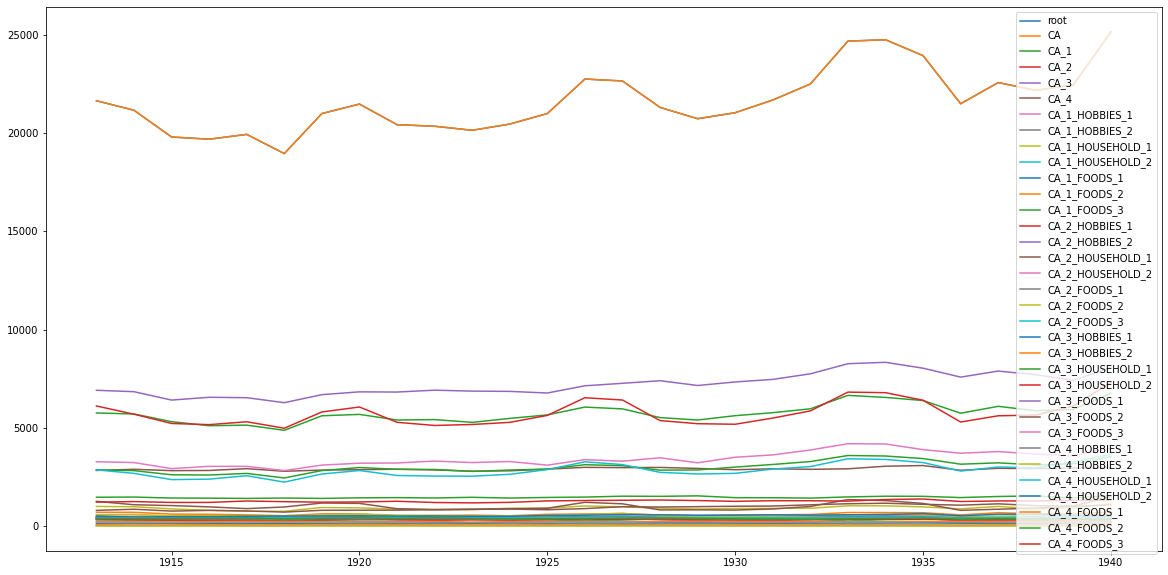

In [ ]:
fjj=fj.bottom_up().plot(figsize=(20,10))   # 'ETS' bottom_up approach

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


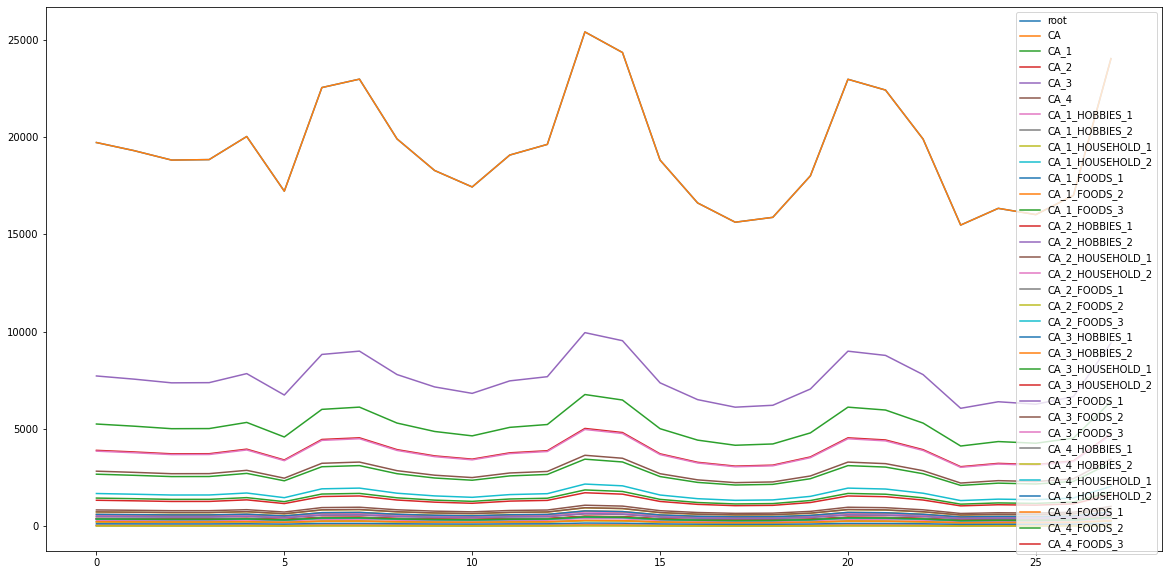

In [ ]:
fj.top_down().plot(figsize=(20,10))  # 'ETS' top_down approach

----------------------------------------------------------------------------------------------------
----------------------------------- Reconciling time step: 1913 ------------------------------------
----------------------------------------------------------------------------------------------------
stop: 2. x approximately solves the least-squares problem according to atol.
n-iterations: 3
r1norm norm(r): 676.9452316154575
Ar-norm: 3.025185948564607e-08
A-norm: 8.544003745317532
A-cond: 7.87246337852573
x-norm: 5880.333500233487
----------------------------------------------------------------------------------------------------
----------------------------------- Reconciling time step: 1914 ------------------------------------
----------------------------------------------------------------------------------------------------
stop: 2. x approximately solves the least-squares problem according to atol.
n-iterations: 3
r1norm norm(r): 720.7566982595032
Ar-norm: 6.335026928381234e-08
A

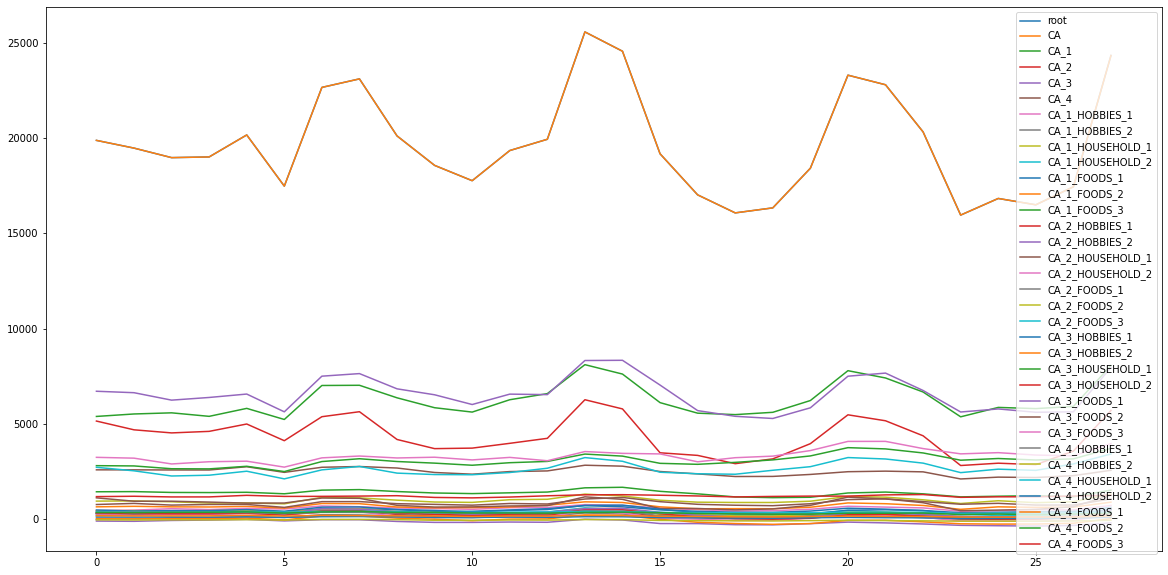

In [ ]:
fj.optimal_combination().plot(figsize=(20,10))  # 'ETS' optimal_combination approach

# make forecast with Bi_lstm, lstm then perform "optimization", "top_down", "bottum_up " roconcilation :

In [ ]:
path2="/content/drive/My Drive/DATA/sales_train_validation.csv"
train = train=pd.read_csv(path2,  encoding='utf-8',engine='c')# .drop('item_id', 1)
train['cat_id']  = (train['store_id'] + '_' + train['cat_id'])
train['dept_id'] = (train['store_id'] + '_' + train['dept_id'])
train['item_id'] = (train['store_id'] + '_' + train['item_id'])

In [ ]:
states = train.state_id.unique()
stores = train.store_id.unique()
depts = train.dept_id.unique()
cats = train.cat_id.unique()
items = train.item_id.unique()

# Here we build the tree as a dictionary. Each node (key in dict) has a list of 
# children value in dict, which in turn may also be a key in the dict, and have 
# children as well 
root = {'root': ['CA']}
state_h = {k: [v for v in stores if v.startswith(k)] for k in states if k.startswith('CA')}
store_h = {k: [v for v in depts if v.startswith(k)] for k in stores if k.startswith('CA')}
dept_h = {k:  [v for v in items if v.startswith(k)] for k in depts if k.startswith('CA')}
#item_h = {k: [v for v in items if v.startswith(k)] for k in depts}    #this could be used to forecast all levels af Hierarchy which we ignore it now.

In [ ]:
import json
# just using "root", "state", "store"
hierarchy2 = {**root, **state_h, **store_h}
path3="/content/drive/My Drive/DATA/processed_M5_hierarchy_untilstore2.csv"
with open(path3, 'w') as j:
    json.dump(hierarchy2, j)

In [ ]:
!pip install mahts
from mahts.distribute import HTSDistributor

     |████████████████████████████████| 51kB 3.8MB/s 
  Created wheel for mahts: filename=mahts-0.1.1-cp36-none-any.whl size=19312 sha256=6eb48150471169e75f4ca8a7d1bf5a0b7e6e64cf68447d0d0a1038074e75e124
  Stored in directory: /root/.cache/pip/wheels/03/73/a7/17dd4147060748bfd12be4590280e3470d282353ccb51d260a
Successfully built mahts


## import :

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers import TimeDistributed
from keras.layers.recurrent import LSTM
from keras.layers import Dense, Conv1D, MaxPool2D, Flatten, Dropout
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam, SGD, Nadam
from time import time
from keras.layers.advanced_activations import LeakyReLU, PReLU
import tensorflow as tf

# model description:

In [44]:
class LSTMs_Hierarchical_forecast():
  def __init__(self, Dataset, modeltype="BILSTM", aggmethod="optimal_combination"):

     #' Dataset= DataFrame you execute model in it,\
     #modeltype= "BILSTM" or "LSTM" , aggmethod="optimal_combination", or\
     #"top_down", or "bottom_up" '

   import pandas as pd
   from keras.models import Sequential
   from keras.layers import LSTM, Dropout, Bidirectional, Dense
   from sklearn.preprocessing import RobustScaler
   pd.options.mode.chained_assignment = None


   rootz=['root']
   storez=[t for t in stores if t.startswith('CA')]
   depz=[t for t in depts if t.startswith('CA')]
   statz=[t for t in states if t.startswith('CA')]
   lp=rootz+statz+storez+depz
   dp=Dataset.loc[:,lp]

   self.aggmethod=aggmethod
   self.modeltype=modeltype
   self.Dataset=dp
   self.columns=dp.columns.tolist()
   self.bt_app=HTSDistributor(hierarchy2)
   self.show_tree=self.bt_app.show_tree()
   
   Y_true=pd.DataFrame()
   forecastt=pd.DataFrame()
   

   #Due to 'method preferation' we 'specify' columns to 'prepare' dataset based on it
   if (self.aggmethod=="optimal_combination"):
    self.columnz=self.columns
  
   elif (self.aggmethod=="top_down"):
    self.columnz=['root']

   elif (self.aggmethod=="bottom_up"):
    self.columnz=[t for t in depts if t.startswith('CA')]

 

   for o in range(len(self.columnz)) :
     #Split Data to Train_Test (train_size=0.8) :
     C=pd.DataFrame(self.Dataset[self.columnz[o]])
     a=int (0.8*len(self.Dataset))
     Train=C[:a]
     Test=C[a:]                                                                                                                           #(153:)
     #Scale train and test set : #target 'y' has no separate sclaing, it would use the same as 'x' but 'train' and 'test' are seperate:       
     f_transformer = RobustScaler()
     f_transformer = f_transformer.fit(pd.DataFrame(Train))
     train= f_transformer.transform(pd.DataFrame(Train))
     test= f_transformer.transform(pd.DataFrame(Test))

     #making x_train and y_train :

     n_steps_in=50 #look_back
     n_steps_out=4 #steps_ahead
     X, y = list(), list()
     for i in range(len(train)):
      # find the end of this pattern
      end_ix = i + n_steps_in
      out_end_ix = end_ix + n_steps_out
      # check if we are beyond the sequence
      if out_end_ix > len(train):
       break
      # gather input and output parts of the pattern
      seq_x, seq_y = train[i:end_ix], train[end_ix:out_end_ix]
      X.append(seq_x)
      y.append(seq_y)
     X_train=np.array(X)
     y_train=np.array(y)

     #making X_test, y_test :
     n_steps_in=50
     n_steps_out=4
     X, y = list(), list()
     for i in range(len(test)):
      # find the end of this pattern
      end_ix = i + n_steps_in
      out_end_ix = end_ix + n_steps_out
      # check if we are beyond the sequence
      if out_end_ix > len(test):
       break
      # gather input and output parts of the pattern
      seq_x, seq_y = test[i:end_ix], test[end_ix:out_end_ix]
      X.append(seq_x)
      y.append(seq_y)
     X_test=np.array(X)
     y_test=np.array(y)

    
     if (self.modeltype=='BILSTM'):
      #Bidirectional Lstm model:
      bimodel = Sequential()
      bimodel.add(Bidirectional(LSTM(128,return_sequences=True),input_shape=(X_train.shape[1], X_train.shape[2])))
      bimodel.add(Bidirectional(LSTM(64)))
      bimodel.add(Dropout(rate=0.2))
      bimodel.add(Dense(1))
      bimodel.compile(optimizer='adam', loss='mse', metrics=['acc'])
      bimodel.summary()
      self.model=bimodel

     elif (self.modeltype=='LSTM'): 
      #lstm model:
      lstm_model = Sequential()
      lstm_model.add(LSTM(128, activation='relu', return_sequences=True, input_shape=(50, 1)))
      lstm_model.add(LSTM(50, activation='relu'))
      lstm_model.add(Dropout(rate=0.3))
      lstm_model.add(Dense(1))
      lstm_model.compile(optimizer='adam', loss='mse', metrics=['acc'])
      lstm_model.summary()
      self.model=lstm_model

     
     history= self.model.fit(X_train, y_train, batch_size=16, validation_split=0.1, epochs=70, shuffle=False)      # epoch=70
     
     y_test0=y_test[:,0] # y_true for later comparision
     y_test_inv = f_transformer.inverse_transform(y_test0)                                                        
     Each_true=pd.DataFrame(y_test_inv, columns=[self.columnz[o]])
     Y_true=pd.concat([Y_true, Each_true], axis=1, sort=False)

     y_hat = self.model.predict(X_test)

     y_pred_inv = f_transformer.inverse_transform(y_hat) #y_prediction
     Each_forecast=pd.DataFrame(y_pred_inv, columns=[self.columnz[o]])
     forecastt=pd.concat([forecastt, Each_forecast], axis=1, sort=False)

   self.forecast=forecastt
   self.Ytrue=Y_true


  def optimal_combination(self):
    optimal=self.bt_app.compute_optimal_combination(forecast=self.forecast)
    return(optimal) 

  def top_down(self):
   forecast_top_down=self.forecast #forecasted "root"
   depz=[t for t in depts if t.startswith('CA')]
   top_d=self.bt_app.compute_top_down(data=self.Dataset[depz], forecast=forecast_top_down, kind="ahp")
   return(top_d)

  def bottom_up(self):
   depz=[t for t in depts if t.startswith('CA')]
   self_forecast_bottom_series=self.forecast
   bottom_up=self.bt_app.compute_bottom_up(forecast=self_forecast_bottom_series)
   return(bottom_up)





# model resualt with "top_down" approach:

In [ ]:
ft=LSTMs_Hierarchical_forecast(Dataset=dataset_ca, modeltype="BILSTM", aggmethod="top_down")

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_2 (Bidirection (None, 50, 256)           133120    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               164352    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 297,601
Trainable params: 297,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/70
84/84 [==============================] - 14s 163ms/step - loss: 0.4545 - acc: 0.0000e+00 - val_loss: 0.6045 - val_acc: 0.0000e+00
Epoch 2/70
84/84 [==============================] - 12s 147ms/step - loss: 0.4198 - acc: 0.0000e+00 - val

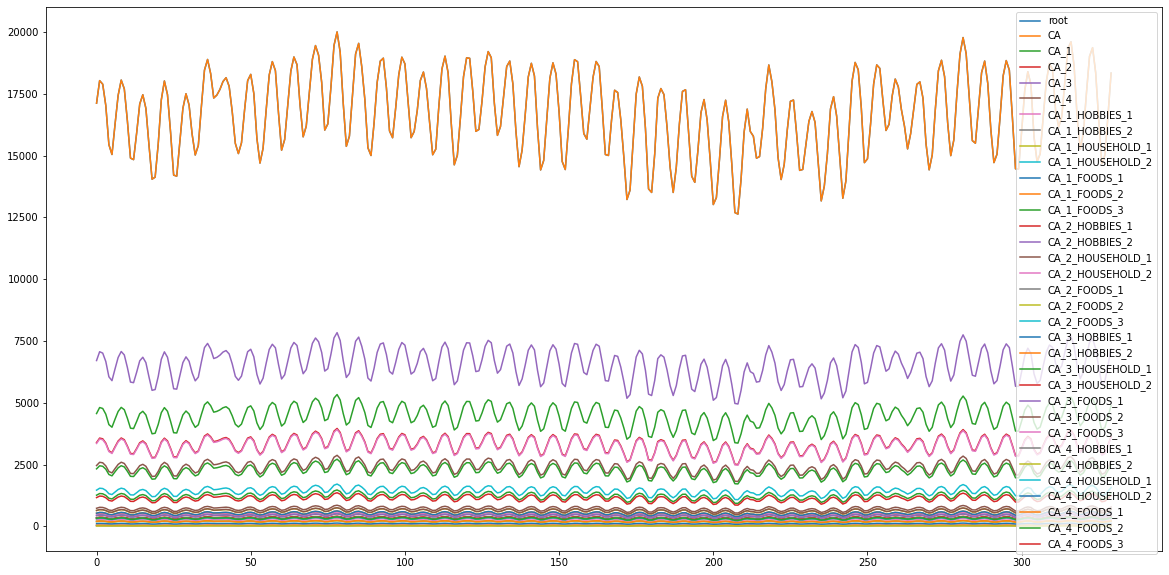

In [ ]:
ft.top_down().plot(figsize=(20,10))

# model resualt with "bottom_up" approach:

In [ ]:
fb=LSTMs_Hierarchical_forecast(Dataset=dataset_ca, modeltype="BILSTM", aggmethod="bottom_up")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 50, 256)           133120    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               164352    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 297,601
Trainable params: 297,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/70
84/84 [==============================] - 12s 149ms/step - loss: 0.4854 - acc: 0.0045 - val_loss: 0.5202 - val_acc: 0.0000e+00
Epoch 2/70
84/84 [==============================] - 12s 138ms/step - loss: 0.4910 - acc: 0.0045 - val_loss: 0.5

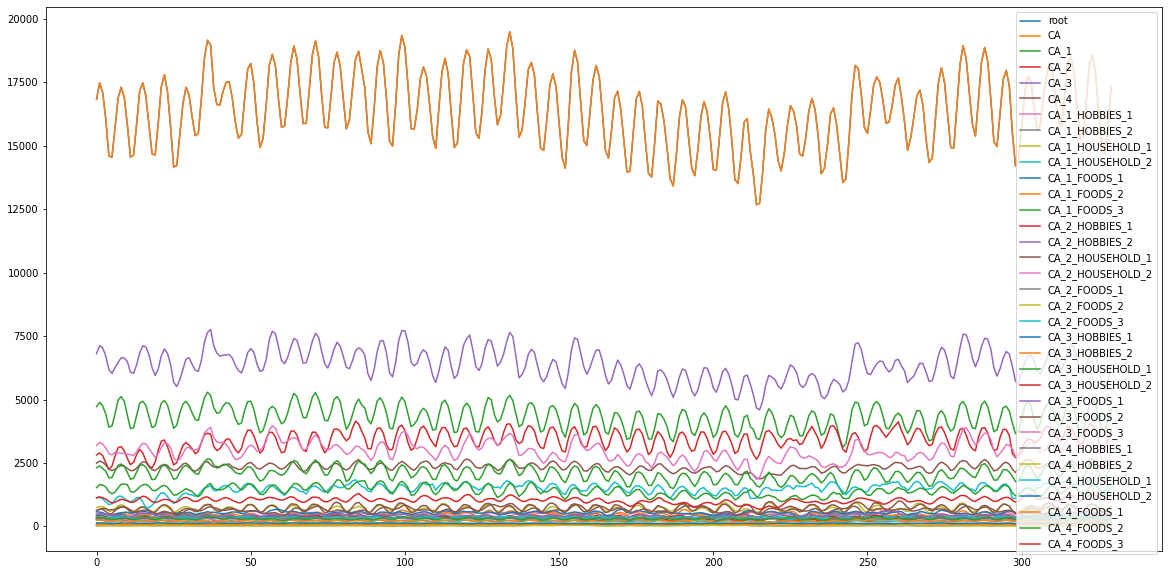

In [ ]:
fb.bottom_up().plot(figsize=(20,10))

# model resualt with "optimal_combination" approach:

In [45]:
fc=LSTMs_Hierarchical_forecast(Dataset=dataset_ca, modeltype="BILSTM", aggmethod="optimal_combination")

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_4 (Bidirection (None, 50, 256)           133120    
_________________________________________________________________
bidirectional_5 (Bidirection (None, 128)               164352    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 297,601
Trainable params: 297,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/70
84/84 [==============================] - 13s 156ms/step - loss: 0.4566 - acc: 0.0000e+00 - val_loss: 0.6071 - val_acc: 0.0000e+00
Epoch 2/70
84/84 [==============================] - 12s 143ms/step - loss: 0.4252 - acc: 0.0000e+00 - val

----------------------------------------------------------------------------------------------------
------------------------------------- Reconciling time step: 0 -------------------------------------
----------------------------------------------------------------------------------------------------
stop: 2. x approximately solves the least-squares problem according to atol.
n-iterations: 4
r1norm norm(r): 579.1828201837993
Ar-norm: 0.0014143031235754333
A-norm: 11.704698892102009
A-cond: 7.94149054325929
x-norm: 4862.877025019718
----------------------------------------------------------------------------------------------------
------------------------------------- Reconciling time step: 1 -------------------------------------
----------------------------------------------------------------------------------------------------
stop: 2. x approximately solves the least-squares problem according to atol.
n-iterations: 4
r1norm norm(r): 506.99738665019026
Ar-norm: 0.0014186500216557092

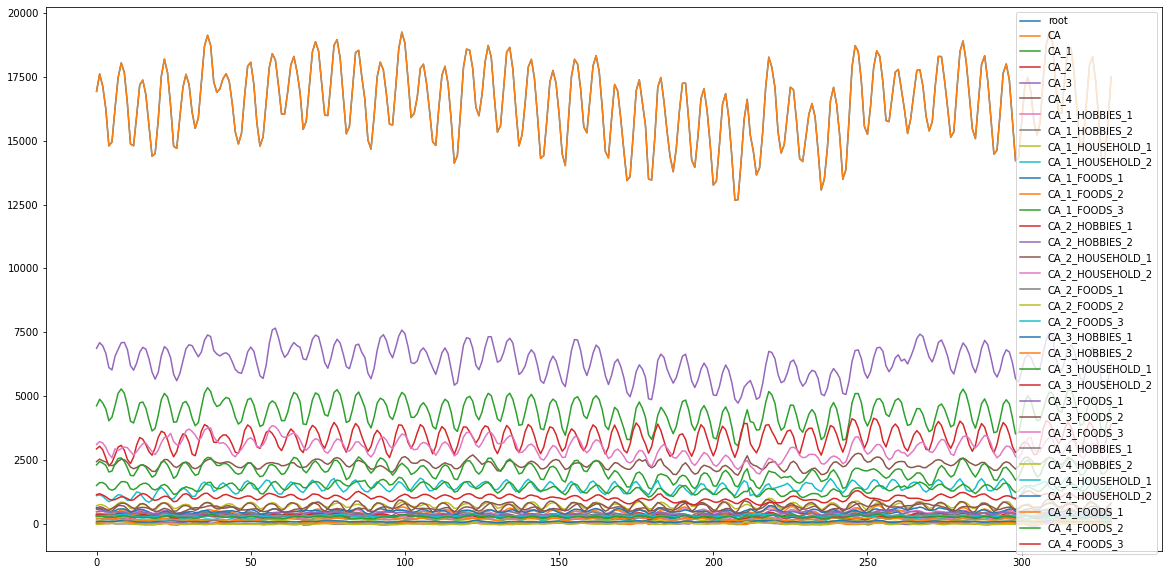

In [46]:
bi_optimal=fc.optimal_combination()
bi_optimal.to_csv('bi_optimal.csv')
bi_optimal.plot(figsize=(20,10))